<a href="https://colab.research.google.com/github/FatherOfLove/257ML/blob/master/IPO_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [0]:
import numpy as np
import pandas as pd# Data and Numbers
import pandas as pd
import numpy as np
import datetime as dt
import statsmodels.api as sm

# Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score,\
precision_recall_curve,f1_score, fbeta_score,\
accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals.six import StringIO
from xgboost import XGBClassifier

# Saving
import joblib
import pickle

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
%matplotlib inline
from matplotlib import rcParams

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

# **import Datasets**

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv("/content/drive/My Drive/MLSpring2020/AIInsight_CrunchbasePrediction/Datasets/crunchbase/newdata.csv",encoding= 'unicode_escape')

In [0]:
#df.head()

In [0]:
df.shape

(8448, 50)

In [0]:
#df.info()

In [0]:
df.Status_new.value_counts()

2    7459
0     964
1      25
Name: Status_new, dtype: int64

# **Data Visualization**

**Missing Values**

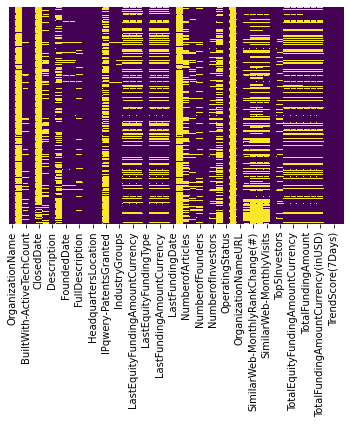

In [0]:
sns.heatmap(df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis')

**Companies Operating Status Imbalance**

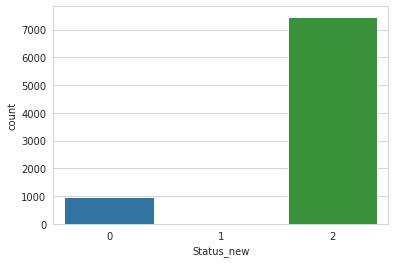

In [0]:
sns.set_style('whitegrid')
sns.countplot(x = 'Status_new', data = df)

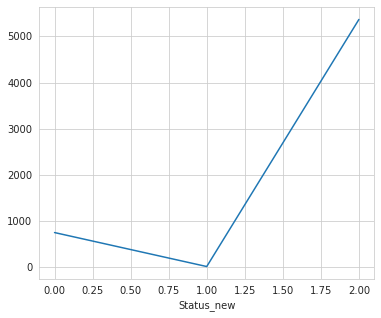

In [0]:
#df.groupby('IndustryGroups') 
#print(df.groupby('IndustryGroups').count()) 
fig, ax = plt.subplots(figsize=(6,5))
df.groupby(['Status_new']).count()['LastFundingAmount'].plot(ax=ax)

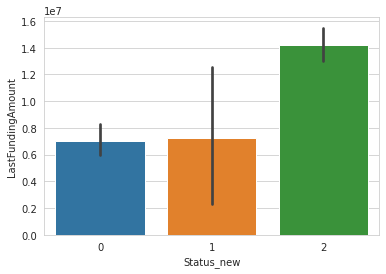

In [0]:
#Last Funding amount of Active companies is more
sns.barplot(x="Status_new",y="LastFundingAmount",data=df)

In [0]:
import plotly.express as px
fig = px.pie(df, values='LastFundingAmountCurrency(inUSD)', names='Status_new')
fig.show()

#**Types of Industries**

In [0]:
# Selecting one Business Category from multiple industries
df['Industries'] = df['Industries'].str.rsplit(',').str[1] 

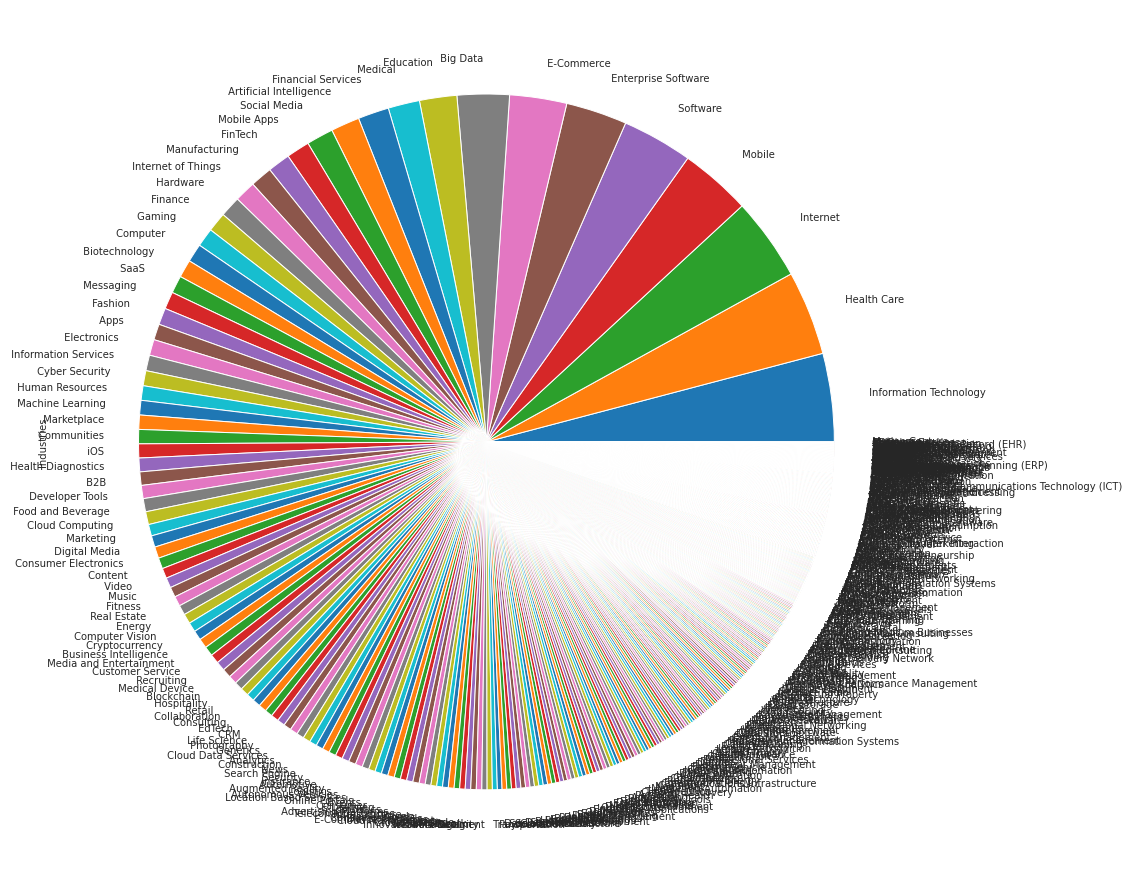

In [0]:
df.Industries.value_counts().plot(kind='pie', figsize=(16, 16))

## define the target value as success and failure

References:


> CrunchBase Reveals: The Average Successful Startup Raises $41M, Exits at $242.9M--https://techcrunch.com/2013/12/14/crunchbase-reveals-the-average-successful-startup-raises-41m-exits-at-242-9m/

> https://www.cbinsights.com/reports/CB%20Insights%20Venture%20Capital%20Exit%20Data%20Comparison.pdf


> How Long Does It Take a Startup to Exit? https://about.crunchbase.com/blog/startup-exit/






In [0]:
#Status_new 0= Closed
#Status_new 1= aqcquired/IPO
#Status_new 2= Active
df.Status_new.value_counts()

2    7459
0     964
1      25
Name: Status_new, dtype: int64

The most important thing of the project is how to define the so-called success  for a startup? 
Changing the world maybe cool,but this cannot be quantified, nor can it give a very clear definition.



> For startups, the traditional definition of success is, of course, the success of an IPO or acquisition by a large company. However, we can see from the database that only 25 of the more than 8,000 companies have successfully IPOed or were acquired. This number is actually very small. If you use such data for machine learning and training, you may not get good results. Therefore, we need to redefine what is success. So that our goal can be yes or no(1/0).



Acording to the references above,we are tring to find more companies from the "Active" category.

>For example, it has survived long enough (not closed) and has obtained enough financing (the amount is m USD).

 We know that a company must first have enough money to pay for employees ’salaries and office rent, and then live long enough to be recognized by the capital market before it can eventually IPO or become the company that really can change the world.

In [0]:
columns_o=df.columns.to_list
columns_o

<bound method IndexOpsMixin.tolist of Index(['OrganizationName', 'AcquisitionStatus', 'BuiltWith-ActiveTechCount',
       'CBRank(Organization)', 'ClosedDate', 'CompanyType', 'Description',
       'EstimatedRevenueRange', 'FoundedDate', 'FoundedDatePrecision',
       'FullDescription', 'FundingStatus', 'HeadquartersLocation', 'IPOStatus',
       'IPqwery-PatentsGranted', 'Industries', 'IndustryGroups',
       'LastEquityFundingAmount', 'LastEquityFundingAmountCurrency',
       'LastEquityFundingAmountCurrency(inUSD)', 'LastEquityFundingType',
       'LastFundingAmount', 'LastFundingAmountCurrency',
       'LastFundingAmountCurrency(inUSD)', 'LastFundingDate',
       'NumberofAcquisitions', 'NumberofArticles', 'NumberofEmployees',
       'NumberofFounders', 'NumberofFundingRounds', 'NumberofInvestors',
       'NumberofLeadInvestors', 'OperatingStatus', 'Unnamed: 33',
       'OrganizationNameURL', 'SimilarWeb-AverageVisits(6months)',
       'SimilarWeb-MonthlyRankChange(#)', 'SimilarWeb-

Maybe we can apply some clustering algorithm to find the m here.

In [0]:
df['TotalEquityFundingAmountCurrency(inUSD)'].describe()

count    6.614000e+03
mean     2.337424e+07
std      8.676618e+07
min      1.000000e+03
25%      4.850000e+05
50%      3.000000e+06
75%      1.500000e+07
max      2.071820e+09
Name: TotalEquityFundingAmountCurrency(inUSD), dtype: float64

The mean of 'TotalEquityFundingAmountCurrency(inUSD)' is $2.33 million here.It seems better than 2013 year.Let us ignore the factor of inflation here.

In [0]:
df['TotalFundingAmountCurrency(inUSD)'].describe()

count    6.677000e+03
mean     2.451944e+07
std      9.212093e+07
min      1.000000e+03
25%      5.000000e+05
50%      3.000000e+06
75%      1.500000e+07
max      2.071820e+09
Name: TotalFundingAmountCurrency(inUSD), dtype: float64

The mean of 'TotalFundingAmount(inUSD)' is $2.45 million here.

Let's plot them

In [0]:
df["TotalFundingAmountCurrency(inUSD)"].fillna(0)

0          575000.0
1        15250000.0
2       228478585.0
3         2000000.0
4        36900000.0
           ...     
8443      9000000.0
8444            0.0
8445     30000000.0
8446            0.0
8447            0.0
Name: TotalFundingAmountCurrency(inUSD), Length: 8448, dtype: float64

In [0]:
df["TotalFundingAmountCurrency(inUSD)"].fillna(0)

0          575000.0
1        15250000.0
2       228478585.0
3         2000000.0
4        36900000.0
           ...     
8443      9000000.0
8444            0.0
8445     30000000.0
8446            0.0
8447            0.0
Name: TotalFundingAmountCurrency(inUSD), Length: 8448, dtype: float64

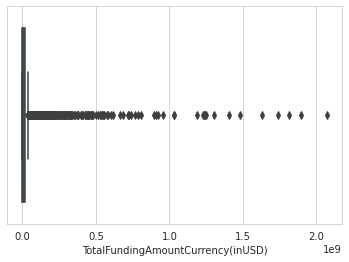

In [0]:
sns.boxplot(x="TotalFundingAmountCurrency(inUSD)", data=df)

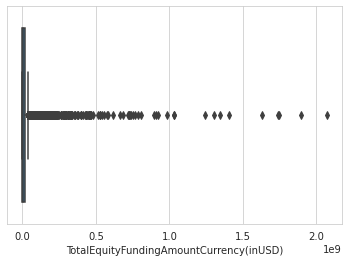

In [0]:
sns.boxplot(x="TotalEquityFundingAmountCurrency(inUSD)", data=df)

In [0]:
for i in range(len(df['TotalFundingAmountCurrency(inUSD)'])):
  if df['TotalFundingAmountCurrency(inUSD)'][i] == df['LastFundingAmountCurrency(inUSD)'][i] and df['Status_new'][i] != 1:
    df['Status_new'][i] = 0
  elif df['TotalFundingAmountCurrency(inUSD)'][i] <= 15000000.0 and df['Status_new'][i] != 1:
    df['Status_new'][i] = 0
  else:
    df['Status_new'][i] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#data cleaning and preprocessing

## **Data narrative**

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8448 entries, 0 to 8447
Data columns (total 50 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   OrganizationName                         8448 non-null   object 
 1   AcquisitionStatus                        418 non-null    object 
 2   BuiltWith-ActiveTechCount                7892 non-null   float64
 3   CBRank(Organization)                     8448 non-null   object 
 4   ClosedDate                               518 non-null    object 
 5   CompanyType                              6403 non-null   object 
 6   Description                              8448 non-null   object 
 7   EstimatedRevenueRange                    4383 non-null   object 
 8   FoundedDate                              8212 non-null   object 
 9   FoundedDatePrecision                     8212 non-null   object 
 10  FullDescription                          7852 no

numbers:

In [0]:
df.describe()

,BuiltWith-ActiveTechCount,IPqwery-PatentsGranted,LastEquityFundingAmount,LastEquityFundingAmountCurrency(inUSD),LastFundingAmount,LastFundingAmountCurrency(inUSD),NumberofAcquisitions,NumberofFounders,NumberofFundingRounds,NumberofInvestors,NumberofLeadInvestors,Unnamed: 33,Status_new,TotalEquityFundingAmount,TotalEquityFundingAmountCurrency(inUSD),TotalFundingAmount,TotalFundingAmountCurrency(inUSD),TrendScore(30Days),TrendScore(7Days),TrendScore(90Days)
count,7892.000000,3123.000000,6.167000e+03,6.167000e+03,6.130000e+03,6.130000e+03,418.000000,7146.000000,8448.000000,6959.000000,3997.000000,0.0,8448.000000,6.614000e+03,6.614000e+03,6.677000e+03,6.677000e+03,8448.000000,8448.000000,8448.000000
mean,22.376964,3.045789,1.326951e+07,1.290183e+07,1.328849e+07,1.290943e+07,1.555024,2.031486,2.206795,5.098290,1.905179,NaN,0.389560,2.356841e+07,2.337424e+07,2.471917e+07,2.451944e+07,0.544022,0.130196,0.804226
std,18.653907,13.315643,4.275189e+07,4.151520e+07,4.372436e+07,4.247941e+07,1.335042,0.995576,1.708541,5.779168,1.333433,NaN,0.487679,8.711167e+07,8.676618e+07,9.246583e+07,9.212093e+07,1.676787,0.929359,2.328609
min,1.000000,0.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.000000,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,-5.300000,-4.100000,-6.800000
25%,8.000000,0.000000,3.427315e+05,3.300000e+05,3.000000e+05,3.000000e+05,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,0.000000,4.999962e+05,4.850000e+05,5.000000e+05,5.000000e+05,-0.200000,-0.300000,-0.400000
50%,18.000000,0.000000,2.500000e+06,2.500000e+06,2.416000e+06,2.400000e+06,1.000000,2.000000,2.000000,3.000000,1.000000,NaN,0.000000,3.000000e+06,3.000000e+06,3.000000e+06,3.000000e+06,-0.100000,-0.100000,-0.100000
75%,32.000000,1.000000,1.038000e+07,1.010000e+07,1.000000e+07,1.000000e+07,2.000000,3.000000,3.000000,7.000000,2.000000,NaN,1.000000,1.500000e+07,1.500000e+07,1.500000e+07,1.500000e+07,0.800000,0.300000,1.200000
max,195.000000,287.000000,1.100000e+09,1.100000e+09,1.100000e+09,1.100000e+09,14.000000,11.000000,20.000000,104.000000,12.000000,NaN,1.000000,2.071820e+09,2.071820e+09,2.071820e+09,2.071820e+09,10.000000,9.700000,10.000000


categorical columns:

In [0]:
def get_cat_columns(data):
  cat_columns_map={}
  cat_columns=[]
  for column in data.select_dtypes(include=[object]):
    cat_columns.append(column)
  for name in   cat_columns:
    cat_columns_map[name]=data[name].unique().tolist()
  return cat_columns_map

In [0]:
cat_columns_map0=get_cat_columns(df)

In [0]:
def get_report_cluster(cat_columns_map,data):
  cat_columns_catNumber={}
  for name in cat_columns_map:
     cat_columns_catNumber[name]=len(data[name].unique().tolist())
  cat_columns_catNumber
  report_cluster={}
  for i in range(0,np.asarray(list(cat_columns_catNumber.values())).max()+1):
      if [j for j,k in cat_columns_catNumber.items() if k == i]:
        report_cluster[i]=[l for l,m in cat_columns_catNumber.items() if m == i]
  return report_cluster

In [0]:
report_cluster0=get_report_cluster(cat_columns_map0,df)
report_cluster0

{1: ['IPOStatus'],
 2: ['AcquisitionStatus', 'OperatingStatus'],
 3: ['CompanyType', 'FundingStatus'],
 4: ['FoundedDatePrecision'],
 9: ['EstimatedRevenueRange'],
 10: ['NumberofEmployees'],
 12: ['LastEquityFundingType'],
 17: ['TotalFundingAmountCurrency'],
 18: ['TotalEquityFundingAmountCurrency'],
 19: ['LastFundingAmountCurrency'],
 20: ['LastEquityFundingAmountCurrency'],
 98: ['HeadquartersLocation'],
 285: ['NumberofArticles'],
 300: ['ClosedDate'],
 532: ['Industries'],
 1429: ['FoundedDate'],
 2851: ['LastFundingDate'],
 3182: ['IndustryGroups'],
 3931: ['SimilarWeb-MonthlyVisits'],
 4055: ['SimilarWeb-MonthlyRankGrowth'],
 4875: ['SimilarWeb-MonthlyRankChange(#)'],
 5756: ['Top5Investors'],
 6288: ['SimilarWeb-AverageVisits(6months)'],
 7763: ['FullDescription'],
 8312: ['OrganizationName'],
 8349: ['Description'],
 8355: ['CBRank(Organization)', 'OrganizationNameURL']}

We can see that some of the features have too many categories here.And many of them not make sense.We will deal with them with features engneering in data preprocessing.

In [0]:
#print("Unique values in each categorical column:")
#cat_columns_map

In [0]:
cat_columns0=cat_columns_map0.keys()
len(cat_columns0)

30

##Data preprocessing

###Data cleaning

In [0]:
df.shape

(8448, 50)

There are 51 features here,it is too many to apply any ML algorithm and input X for predict.So we must reduce dimension here.

Removing the unimportant features will help with memory, computational cost and the accuracy of our model.Also, it will help to avoid the overfitting. Sometimes, a feature that makes business sense, but it doesn’t mean that this feature will help us with our prediction.

In [0]:
df.columns

Index(['OrganizationName', 'AcquisitionStatus', 'BuiltWith-ActiveTechCount',
       'CBRank(Organization)', 'ClosedDate', 'CompanyType', 'Description',
       'EstimatedRevenueRange', 'FoundedDate', 'FoundedDatePrecision',
       'FullDescription', 'FundingStatus', 'HeadquartersLocation', 'IPOStatus',
       'IPqwery-PatentsGranted', 'Industries', 'IndustryGroups',
       'LastEquityFundingAmount', 'LastEquityFundingAmountCurrency',
       'LastEquityFundingAmountCurrency(inUSD)', 'LastEquityFundingType',
       'LastFundingAmount', 'LastFundingAmountCurrency',
       'LastFundingAmountCurrency(inUSD)', 'LastFundingDate',
       'NumberofAcquisitions', 'NumberofArticles', 'NumberofEmployees',
       'NumberofFounders', 'NumberofFundingRounds', 'NumberofInvestors',
       'NumberofLeadInvestors', 'OperatingStatus', 'Unnamed: 33',
       'OrganizationNameURL', 'SimilarWeb-AverageVisits(6months)',
       'SimilarWeb-MonthlyRankChange(#)', 'SimilarWeb-MonthlyRankGrowth',
       'SimilarWeb

Some features (such as 'CBRank(Organization)','Description','FullDescription','OrganizationNameURL','SimilarWeb-AverageVisits(6months)','SimilarWeb-MonthlyRankChange(#)', 'SimilarWeb-MonthlyRankGrowth',
       'SimilarWeb-MonthlyVisits', 'TrendScore(30Days)', 'TrendScore(7Days)', 'TrendScore(90Days)') are duplicate and some of them (such as permalink,company_name) will not help us with our prediction.We drop them first.

In [0]:
useless_cols=['CBRank(Organization)','Description','FullDescription','OrganizationNameURL','SimilarWeb-AverageVisits(6months)','SimilarWeb-MonthlyRankChange(#)',
             'SimilarWeb-MonthlyRankGrowth', 'SimilarWeb-MonthlyVisits', 'TrendScore(30Days)', 'TrendScore(7Days)', 'TrendScore(90Days)']

In [0]:
df_clean=df.copy()

In [0]:
df_clean['target'] = df['Status_new']

In [0]:
for col in useless_cols:
   df_clean.drop([col],axis=1,inplace=True)

In [0]:
df_clean.shape

(8448, 40)

Some of other features(such as  'AcquisitionStatus', 'ClosedDate', 'IPOStatus','LastEquityFundingAmount', 'LastEquityFundingAmountCurrency', 'LastEquityFundingAmountCurrency(inUSD)', 'LastFundingAmount', LastFundingAmountCurrency','LastFundingAmountCurrency(inUSD)', 'OperatingStatus', 'Status_new', 'TotalEquityFundingAmount', 'TotalEquityFundingAmountCurrency','TotalEquityFundingAmountCurrency(inUSD)', 'TotalFundingAmount', 'TotalFundingAmountCurrency', 'TotalFundingAmountCurrency(inUSD)'）.All of them related to the features 'status'and 'TotalFundingAmountCurrency(inUSD)'  ,which have been used by us to define the so-called success, if you keep them, it is equivalent to a repetition.So we drop them.

In [0]:
status_relate_cols=['AcquisitionStatus', 'ClosedDate', 'IPOStatus','LastEquityFundingAmount', 'LastEquityFundingAmountCurrency', 'LastEquityFundingAmountCurrency(inUSD)', 
 'LastFundingAmount', 'LastFundingAmountCurrency','LastFundingAmountCurrency(inUSD)', 'OperatingStatus', 'Status_new', 'TotalEquityFundingAmount', 
'TotalEquityFundingAmountCurrency','TotalEquityFundingAmountCurrency(inUSD)', 'TotalFundingAmount', 'TotalFundingAmountCurrency', 'TotalFundingAmountCurrency(inUSD)']

In [0]:
for col in status_relate_cols:
    df_clean.drop([col],axis=1,inplace=True)

In [0]:
df_clean.shape

(8448, 23)

In [0]:
df_clean.head(2)

,OrganizationName,BuiltWith-ActiveTechCount,CompanyType,EstimatedRevenueRange,FoundedDate,FoundedDatePrecision,FundingStatus,HeadquartersLocation,IPqwery-PatentsGranted,Industries,IndustryGroups,LastEquityFundingType,LastFundingDate,NumberofAcquisitions,NumberofArticles,NumberofEmployees,NumberofFounders,NumberofFundingRounds,NumberofInvestors,NumberofLeadInvestors,Unnamed: 33,Top5Investors,target
0,C. Light Technologies,11.0,For Profit,NaN,9/1/14,month,Seed,"Berkeley, California, United States",NaN,Software,"Health Care, Software",Pre-Seed,1/1/17,NaN,2,10-Jan,2.0,1,2.0,NaN,NaN,"National Institutes of Health, C. Light Ventures",0
1,C1X,23.0,For Profit,Less than $1M,1/1/14,year,Early Stage Venture,"San Jose, California, United States",NaN,E-Commerce,"Advertising, Commerce and Shopping, Internet S...",Series B,10/12/16,NaN,12,51-100,2.0,2,5.0,2.0,NaN,"UTEC- University of Tokyo Edge Capital, Mynavi...",1


In [0]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8448 entries, 0 to 8447
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OrganizationName           8448 non-null   object 
 1   BuiltWith-ActiveTechCount  7892 non-null   float64
 2   CompanyType                6403 non-null   object 
 3   EstimatedRevenueRange      4383 non-null   object 
 4   FoundedDate                8212 non-null   object 
 5   FoundedDatePrecision       8212 non-null   object 
 6   FundingStatus              8448 non-null   object 
 7   HeadquartersLocation       8448 non-null   object 
 8   IPqwery-PatentsGranted     3123 non-null   float64
 9   Industries                 7854 non-null   object 
 10  IndustryGroups             8346 non-null   object 
 11  LastEquityFundingType      8448 non-null   object 
 12  LastFundingDate            8448 non-null   object 
 13  NumberofAcquisitions       418 non-null    float

Let's find the data of the features which are null？

In [0]:
def cal_missing_data(data):
  missing_data = data.isnull().sum().sort_values(ascending = False)
  missing_data_rate = (data.isnull().sum()/data.isnull().count()).sort_values(ascending = False)
  print(missing_data_rate)

In [0]:
cal_missing_data(df_clean)

Unnamed: 33                  1.000000
NumberofAcquisitions         0.950521
IPqwery-PatentsGranted       0.630327
NumberofLeadInvestors        0.526870
EstimatedRevenueRange        0.481179
NumberofArticles             0.409683
CompanyType                  0.242069
NumberofInvestors            0.176255
Top5Investors                0.176255
NumberofFounders             0.154119
NumberofEmployees            0.138968
Industries                   0.070312
BuiltWith-ActiveTechCount    0.065814
FoundedDate                  0.027936
FoundedDatePrecision         0.027936
IndustryGroups               0.012074
target                       0.000000
LastEquityFundingType        0.000000
FundingStatus                0.000000
HeadquartersLocation         0.000000
LastFundingDate              0.000000
NumberofFundingRounds        0.000000
OrganizationName             0.000000
dtype: float64


Some features are too many missing data(such as "avg_time_bw_rounds"), it does n’t make much sense to keep or fill, so they also should be deleted.

In [0]:
df_clean.drop(['Unnamed: 33'],axis=1,inplace=True)
df_clean.drop(['NumberofAcquisitions'],axis=1,inplace=True)

Some features are not too many missing(such as "FoundedDatePrecision","FoundedDate"),we can just remove the missing data.And we will deal with the two columns to become one later.

In [0]:
df_clean.dropna(subset=['FoundedDatePrecision'],axis=0, inplace = True)
df_clean.dropna(subset=['FoundedDate'],axis=0,inplace=True)

In [0]:
df_clean.isnull().sum().sort_values(ascending = False)

IPqwery-PatentsGranted       5125
NumberofLeadInvestors        4268
EstimatedRevenueRange        3882
NumberofArticles             3248
CompanyType                  1946
NumberofInvestors            1453
Top5Investors                1453
NumberofFounders             1169
NumberofEmployees            1028
Industries                    540
BuiltWith-ActiveTechCount     474
IndustryGroups                 90
FoundedDatePrecision            0
FoundedDate                     0
target                          0
FundingStatus                   0
HeadquartersLocation            0
LastEquityFundingType           0
LastFundingDate                 0
NumberofFundingRounds           0
OrganizationName                0
dtype: int64

We should fill them.Let's analysis them.

In [0]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8212 entries, 0 to 8447
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OrganizationName           8212 non-null   object 
 1   BuiltWith-ActiveTechCount  7738 non-null   float64
 2   CompanyType                6266 non-null   object 
 3   EstimatedRevenueRange      4330 non-null   object 
 4   FoundedDate                8212 non-null   object 
 5   FoundedDatePrecision       8212 non-null   object 
 6   FundingStatus              8212 non-null   object 
 7   HeadquartersLocation       8212 non-null   object 
 8   IPqwery-PatentsGranted     3087 non-null   float64
 9   Industries                 7672 non-null   object 
 10  IndustryGroups             8122 non-null   object 
 11  LastEquityFundingType      8212 non-null   object 
 12  LastFundingDate            8212 non-null   object 
 13  NumberofArticles           4964 non-null   objec

Fill some of them with 0(IPqwery-PatentsGranted and BuiltWith-ActiveTechCount,which only some companies have these)

In [0]:
df_clean['BuiltWith-ActiveTechCount']=df_clean['BuiltWith-ActiveTechCount'].fillna(0)
df_clean['IPqwery-PatentsGranted']=df_clean['IPqwery-PatentsGranted'].fillna(0)
df_clean['NumberofInvestors']=df_clean['NumberofInvestors'].fillna(0)    
df_clean['NumberofLeadInvestors']=df_clean['NumberofLeadInvestors'].fillna(0)   

Fill some of them with mean.

In [0]:
df_clean['NumberofFounders']=df_clean['NumberofFounders'].fillna(df_clean['NumberofFounders'].mean())

In [0]:
df_clean.isnull().sum().sort_values(ascending = False)

EstimatedRevenueRange        3882
NumberofArticles             3248
CompanyType                  1946
Top5Investors                1453
NumberofEmployees            1028
Industries                    540
IndustryGroups                 90
HeadquartersLocation            0
BuiltWith-ActiveTechCount       0
FoundedDate                     0
FoundedDatePrecision            0
FundingStatus                   0
target                          0
IPqwery-PatentsGranted          0
LastEquityFundingType           0
LastFundingDate                 0
NumberofFounders                0
NumberofFundingRounds           0
NumberofInvestors               0
NumberofLeadInvestors           0
OrganizationName                0
dtype: int64

In [0]:
cat_columns_map1=get_cat_columns(df_clean)
report_cluster1=get_report_cluster(cat_columns_map1,df_clean)
report_cluster1

{3: ['CompanyType', 'FoundedDatePrecision', 'FundingStatus'],
 9: ['EstimatedRevenueRange'],
 10: ['NumberofEmployees'],
 12: ['LastEquityFundingType'],
 97: ['HeadquartersLocation'],
 285: ['NumberofArticles'],
 529: ['Industries'],
 1428: ['FoundedDate'],
 2804: ['LastFundingDate'],
 3146: ['IndustryGroups'],
 5676: ['Top5Investors'],
 8081: ['OrganizationName']}

In [0]:
pd.set_option('display.max_columns', None)
def style_specific_cell(x):
    color_thresh = 'background-color: lightgreen'   
    df_color = pd.DataFrame('', index=x.index, columns=x.columns)
    rows_number=len(x.index)
    column_number=len(x.columns)
    for r in range(0,rows_number): 
        for c in range(0,column_number):
            try:
                val=float(x.iloc[r, c])
                if x.iloc[r, 0]=="%":
                    if val<10:
                        df_color.iloc[r, c]=color_thresh
            except:
                pass            
    return df_color

In [0]:
def make_percent_report(report_cluster,key,df):
    percentage_report=[]
    for name in sorted(report_cluster[key]):
        data=pd.crosstab(df[name],columns=["%"]).apply(lambda r: (round((r/r.sum())*100,2)), axis=0).reset_index()
        data.columns=[name,"%"]
        data=data.transpose().reset_index()
        [percentage_report.append(x) for x in data.values.tolist()]
        options=[]
    percentage_report=pd.DataFrame(percentage_report)
    [options.append("Category"+str(itr)) for itr in range(1,len(percentage_report.columns))]
    percentage_report.columns=["Features"]+options
    display(percentage_report.style.apply(style_specific_cell, axis=None))

In [0]:
for key in report_cluster1.keys():
  if key<12:
    make_percent_report(report_cluster1,key,df)

,Features,Category1,Category2,Category3
0,CompanyType,For Profit,Non-profit,None
1,%,99.610000,0.390000,None
2,FoundedDatePrecision,day,month,year
3,%,33.580000,9.270000,57.150000
4,FundingStatus,Early Stage Venture,Late Stage Venture,Seed
5,%,27.890000,9.690000,62.420000


,Features,Category1,Category2,Category3,Category4,Category5,Category6,Category7,Category8
0,EstimatedRevenueRange,$100M to $500M,$10B+,$10M to $50M,$1B to $10B,$1M to $10M,$500M to $1B,$50M to $100M,Less than $1M
1,%,1.230000,0.050000,9.030000,0.160000,56.130000,0.090000,1.160000,32.150000


,Features,Category1,Category2,Category3,Category4,Category5,Category6,Category7,Category8,Category9
0,NumberofEmployees,10-Jan,10001+,1001-5000,101-250,251-500,5001-10000,501-1000,51-100,Nov-50
1,%,45.770000,0.080000,0.380000,5.440000,1.510000,0.050000,0.870000,7.050000,38.840000


Some of other features don't seem to be the things that explicitly impacts success,we drop them.

In [0]:
df_clean.drop(['NumberofArticles'],axis=1,inplace=True)

There is only 0.39% of "Non-profit" in "CompanyType" feature here. The ratio is so low, this feature will become outliers which will affect our algorithm implementation, and it don't make sense , we can remove this feature first.

In [0]:
df_clean.drop(['CompanyType'],axis=1,inplace=True)

###Merge the categarical features

####NumberofEmployees

In [0]:
df_clean['NumberofEmployees'].value_counts()

10-Jan        3258
Nov-50        2810
51-100         513
101-250        394
251-500        110
501-1000        62
1001-5000       28
10001+           5
5001-10000       4
Name: NumberofEmployees, dtype: int64

We can merge the >100 categaries.

In [0]:
df_clean['NumberofEmployees']=df_clean['NumberofEmployees'].fillna('unknown')


In [0]:
df_clean['NumberofEmployees'] = df_clean['NumberofEmployees'].replace('10-Jan',"less than 10")
df_clean['NumberofEmployees'] = df_clean['NumberofEmployees'].replace('Nov-50',"11 to 50")
df_clean['NumberofEmployees'] = df_clean['NumberofEmployees'].replace('51-100',"51 to 100")
df_clean['NumberofEmployees'] = df_clean['NumberofEmployees'].replace('101-250',"more than 100")
df_clean['NumberofEmployees'] = df_clean['NumberofEmployees'].replace('251-500',"more than 100")
df_clean['NumberofEmployees'] = df_clean['NumberofEmployees'].replace('501-1000',"more than 100")
df_clean['NumberofEmployees'] = df_clean['NumberofEmployees'].replace('1001-5000',"more than 100")
df_clean['NumberofEmployees'] = df_clean['NumberofEmployees'].replace('10001+',"more than 100")
df_clean['NumberofEmployees'] = df_clean['NumberofEmployees'].replace('5001-10000',"more than 100")

In [0]:
df_clean['NumberofEmployees'].value_counts()

less than 10     3258
11 to 50         2810
unknown          1028
more than 100     603
51 to 100         513
Name: NumberofEmployees, dtype: int64

In [0]:
df_clean['NumberofEmployees']=df_clean['NumberofEmployees']

####EstimatedRevenueRange


In [0]:
df_clean['EstimatedRevenueRange'].value_counts()

$1M to $10M       2432
Less than $1M     1385
$10M to $50M       395
$100M to $500M      54
$50M to $100M       51
$1B to $10B          7
$500M to $1B         4
$10B+                2
Name: EstimatedRevenueRange, dtype: int64

You know, if the company EstimatedRevenueRange is more than 10M usd,I think it is not a start-up now.So 10M+ usd should be a type here.

In [0]:
EstimatedRevenueRange={'$1M to $10M':"$1M to $10M",'Less than $1M':"Less than $1M",
                       '$10M to $50M':"$10M+", '$100M to $500M':"$10M+",'$50M to $100M':"$10M+",
                       '$1B to $10B':"$10M+",'$500M to $1B':"$10M+",'$10B+':"$10M+"}
df_clean['EstimatedRevenueRange']=df_clean['EstimatedRevenueRange'].map(EstimatedRevenueRange)

In [0]:
df_clean['EstimatedRevenueRange'].value_counts()

$1M to $10M      2432
Less than $1M    1385
$10M+             513
Name: EstimatedRevenueRange, dtype: int64

In [0]:
df_clean['EstimatedRevenueRange']=df_clean['EstimatedRevenueRange'].fillna('unknown')

In [0]:
df_clean['EstimatedRevenueRange'].value_counts()

unknown          3882
$1M to $10M      2432
Less than $1M    1385
$10M+             513
Name: EstimatedRevenueRange, dtype: int64

####Top5Investors (1453 missing)

In [0]:
df_clean['Top5Investors'].value_counts()

Y Combinator                                                                       295
500 Startups                                                                       107
Plug and Play                                                                       63
Start-Up Chile                                                                      30
Alchemist Accelerator                                                               25
                                                                                  ... 
Splunk, Real Ventures, August Capital, Data Collective DCVC, Erik Swan               1
MakeMyTrip.com                                                                       1
Redpoint, Gokul Rajaram, Milliways Ventures, Venky Harinarayan, Anand Rajaraman      1
Y Combinator, Draper Associates, Greg Castle                                         1
Verizon Ventures, bm-t beteiligungsmanagement thuringen                              1
Name: Top5Investors, Length: 5675, dtype: i

['Y Combinator',                       'Startups',
'Plug and Play',
'Start-Up Chile','Alchemist Accelerator']are the most famous Investor, but some of others are not.We can make a list of famous investors.

In [0]:
famous_investor=['Y Combinator',  '500 Startups', 'Plug and Play',
                 'Start-Up Chile','Alchemist Accelerator']

##Latent Manifold

###Now,we can get the Latent Manifold here, if the company was invested by famous investors.It seems that companies invested by well-known investment institutions may be more likely to succeed because they have an invisible endorsement

###Get the inv_by_famous_investor by the Top5Investors.

In [0]:
df_clean['Top5Investors']=df_clean['Top5Investors'].fillna('none')

In [0]:
list_inv=df_clean['Top5Investors'].values.tolist()

In [0]:
len(list_inv)

8212

In [0]:
df_clean.shape

(8212, 19)

In [0]:
df_clean['inv_by_famous_investor']=None

In [0]:
df_clean['inv_by_famous_investor']=df_clean['inv_by_famous_investor'].fillna(0)

In [0]:
famous_investor

['Y Combinator',
 '500 Startups',
 'Plug and Play',
 'Start-Up Chile',
 'Alchemist Accelerator']

In [0]:
for inv_name in famous_investor:
  print(inv_name)
  for i in range(df_clean.shape[0]):     
    if df_clean['Top5Investors'].values[i]==inv_name:
      df_clean['inv_by_famous_investor'][i]=1
    if  inv_name in df_clean['Top5Investors'].values[i]:
      df_clean['inv_by_famous_investor'][i]=1

Y Combinator
500 Startups
Plug and Play


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Start-Up Chile
Alchemist Accelerator


In [0]:
df_clean['inv_by_famous_investor']=df_clean['inv_by_famous_investor'].fillna(0)

In [0]:
df_clean['inv_by_famous_investor'].value_counts()

0    6678
1    1534
Name: inv_by_famous_investor, dtype: int64

In [0]:
df_clean.drop(['Top5Investors'],axis=1,inplace=True)

In [0]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8212 entries, 0 to 8447
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OrganizationName           8212 non-null   object 
 1   BuiltWith-ActiveTechCount  8212 non-null   float64
 2   EstimatedRevenueRange      8212 non-null   object 
 3   FoundedDate                8212 non-null   object 
 4   FoundedDatePrecision       8212 non-null   object 
 5   FundingStatus              8212 non-null   object 
 6   HeadquartersLocation       8212 non-null   object 
 7   IPqwery-PatentsGranted     8212 non-null   float64
 8   Industries                 7672 non-null   object 
 9   IndustryGroups             8122 non-null   object 
 10  LastEquityFundingType      8212 non-null   object 
 11  LastFundingDate            8212 non-null   object 
 12  NumberofEmployees          8212 non-null   object 
 13  NumberofFounders           8212 non-null   float

In [0]:
cat_columns_map2=get_cat_columns(df_clean)
report_cluster2=get_report_cluster(cat_columns_map2,df_clean)
report_cluster2

{3: ['FoundedDatePrecision', 'FundingStatus'],
 4: ['EstimatedRevenueRange'],
 5: ['NumberofEmployees'],
 12: ['LastEquityFundingType'],
 97: ['HeadquartersLocation'],
 529: ['Industries'],
 1428: ['FoundedDate'],
 2804: ['LastFundingDate'],
 3146: ['IndustryGroups'],
 8081: ['OrganizationName']}

###Get the Business type of companies by the Industries

> The time it takes for a startup to exit depends on the industry.



In [0]:
df_new = df_clean[['Industries']]

In [0]:
df_new['Industries'] = df_new['Industries'].astype(str)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
df_new

,Industries
0,Software
1,E-Commerce
2,Big Data
3,Software
4,Electronics
...,...
8443,nan
8444,Gaming
8445,Enterprise Software
8446,Career Planning


In [0]:
for i in range(len(df['Industries'])):
    af = df_new['Industries'].values[i]
    bf = af.split(',',1)[0]
    cf = bf.lower() 
    df_new['Industries'][i] = cf

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
df_clean['Buessiness'] = df_new['Industries']

In [0]:
df_clean.Buessiness.value_counts()

nan                        540
 information technology    316
 internet                  296
 health care               294
 mobile                    250
                          ... 
 app discovery               1
 video on demand             1
 comics                      1
 mining                      1
 mapping services            1
Name: Buessiness, Length: 529, dtype: int64

In [0]:
df_clean.drop(['IndustryGroups'],axis=1,inplace=True)

In [0]:
df_clean.drop(['Industries'],axis=1,inplace=True)

In [0]:
df_clean.columns

Index(['OrganizationName', 'BuiltWith-ActiveTechCount',
       'EstimatedRevenueRange', 'FoundedDate', 'FoundedDatePrecision',
       'FundingStatus', 'HeadquartersLocation', 'IPqwery-PatentsGranted',
       'LastEquityFundingType', 'LastFundingDate', 'NumberofEmployees',
       'NumberofFounders', 'NumberofFundingRounds', 'NumberofInvestors',
       'NumberofLeadInvestors', 'target', 'inv_by_famous_investor',
       'Buessiness'],
      dtype='object')

In [0]:
cat_columns_map3=get_cat_columns(df_clean)
report_cluster3=get_report_cluster(cat_columns_map3,df_clean)
report_cluster3

{3: ['FoundedDatePrecision', 'FundingStatus'],
 4: ['EstimatedRevenueRange'],
 5: ['NumberofEmployees'],
 12: ['LastEquityFundingType'],
 97: ['HeadquartersLocation'],
 529: ['Buessiness'],
 1428: ['FoundedDate'],
 2804: ['LastFundingDate'],
 8081: ['OrganizationName']}

Here,OrganizationName just for index.

####HeadquartersLocation

In [0]:
df_clean['HeadquartersLocation'].value_counts()

San Francisco, California, United States    4023
Palo Alto, California, United States         641
San Jose, California, United States          445
Mountain View, California, United States     410
Sunnyvale, California, United States         290
                                            ... 
San Martin, California, United States          1
Saint Helena, California, United States        1
Fairfield, California, United States           1
Watsonville, California, United States         1
Cotati, California, United States              1
Name: HeadquartersLocation, Length: 97, dtype: int64

All of them base at Bay Area, maybe we can location them to some fewer locations.

In [0]:
make_percent_report(report_cluster3,97,df_clean)

,Features,Category1,Category2,Category3,Category4,Category5,Category6,Category7,Category8,Category9,Category10,Category11,Category12,Category13,Category14,Category15,Category16,Category17,Category18,Category19,Category20,Category21,Category22,Category23,Category24,Category25,Category26,Category27,Category28,Category29,Category30,Category31,Category32,Category33,Category34,Category35,Category36,Category37,Category38,Category39,Category40,Category41,Category42,Category43,Category44,Category45,Category46,Category47,Category48,Category49,Category50,Category51,Category52,Category53,Category54,Category55,Category56,Category57,Category58,Category59,Category60,Category61,Category62,Category63,Category64,Category65,Category66,Category67,Category68,Category69,Category70,Category71,Category72,Category73,Category74,Category75,Category76,Category77,Category78,Category79,Category80,Category81,Category82,Category83,Category84,Category85,Category86,Category87,Category88,Category89,Category90,Category91,Category92,Category93,Category94,Category95,Category96,Category97
0,HeadquartersLocation,"Alameda, California, United States","Albany, California, United States","American Canyon, California, United States","Antioch, California, United States","Aptos, California, United States","Atherton, California, United States","Belmont, California, United States","Belvedere Tiburon, California, United States","Berkeley, California, United States","Boyes Hot Springs, California, United States","Brisbane, California, United States","Burlingame, California, United States","Byron, California, United States","Campbell, California, United States","Castro Valley, California, United States","Concord, California, United States","Corte Madera, California, United States","Cotati, California, United States","Cupertino, California, United States","Daly City, California, United States","Danville, California, United States","Dublin, California, United States","East Palo Alto, California, United States","El Cerrito, California, United States","Emeryville, California, United States","Fairfax, California, United States","Fairfield, California, United States","Foster City, California, United States","Fremont, California, United States","Gilroy, California, United States","Graton, California, United States","Half Moon Bay, California, United States","Hayward, California, United States","Healdsburg, California, United States","Hercules, California, United States","Kentfield, California, United States","La Honda, California, United States","Lafayette, California, United States","Larkspur, California, United States","Livermore, California, United States","Los Altos Hills, California, United States","Los Altos, California, United States","Los Gatos, California, United States","Martinez, California, United States","Menlo Park, California, United States","Mill Valley, California, United States","Millbrae, California, United States","Milpitas, California, United States","Moraga, California, United States","Morgan Hill, California, United States","Moss Beach, California, United States","Mountain View, California, United States","Napa, California, United States","Newark, California, United States","Novato, California, United States","Oakland, California, United States","Orinda, California, United States","Pacifica, California, United States","Palo Alto, California, United States","Petaluma, California, United States","Pleasant Hill, California, United States","Pleasanton, California, United States","Portola Valley, California, United States","Redwood City, California, United States","Redwood Shores, California, United States","Richmond, California, United States","Rohnert Park, California, United States","Saint Helena, California, United States","San Anselmo, California, United States","San Bruno, California, United States","San Carlos, California, United States","San Francisco, California, United States","San Jose, California, United States","San Juan Bautista, California, United Sta

Most of them base on SF(4023,48.99%) and around SF(South San Francisco,Menlo Park,Millbrae,Redwood City,San Carlos,San Bruno),some of them base on south bay(Palo Alto,San Jose,Stanford,Mountain Vie,Sunnyvale,Santa Clara,Saratoga,Milpitas,Los Altos,Los Gatos),few of them base on north and east bay(around Berkeley,Oakland,Fremont,Newark),and other cities.

So merge them here.

To 4 kinds: SF/Around_SF,South_Bay,North_East_Bay,Others

In [0]:
Sf_around=['San Francisco','South San Francisco','Menlo Park','Millbrae','Redwood City','San Carlos']
South_Bay=['Palo Alto','San Jose','Stanford','Mountain View','Sunnyvale','Santa Clara','Saratoga','Milpitas','Los Altos','Los Gatos']
North_East_Bay=['Berkeley','Oakland','Fremont','Newark']

In [0]:
df_clean['HeadquartersLocation'].index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            8438, 8439, 8440, 8441, 8442, 8443, 8444, 8445, 8446, 8447],
           dtype='int64', length=8212)

In [0]:
df_clean['HeadquartersLocation2']='others'

In [0]:
df_clean['HeadquartersLocation']=df_clean['HeadquartersLocation'].fillna('others')

In [0]:
for city_name in Sf_around:
  print(city_name)
  for i in range(df_clean.shape[0]):
    af = df_clean['HeadquartersLocation'].values[i]
    bf = af.split(',',1)[0]     
    if  city_name in bf:
      df_clean['HeadquartersLocation2'].values[i]='Sf_around'

San Francisco
South San Francisco
Menlo Park
Millbrae
Redwood City
San Carlos


In [0]:
for city_name in South_Bay:
  print(city_name)
  for i in range(df_clean.shape[0]):
    af = df_clean['HeadquartersLocation'].values[i]
    bf = af.split(',',1)[0]     
    if  city_name in bf:      
      df_clean['HeadquartersLocation2'].values[i]='South_Bay'

Palo Alto
San Jose
Stanford
Mountain View
Sunnyvale
Santa Clara
Saratoga
Milpitas
Los Altos
Los Gatos


In [0]:
for city_name in North_East_Bay:
  print(city_name)
  for i in range(df_clean.shape[0]):     
    af = df_clean['HeadquartersLocation'].values[i]
    bf = af.split(',',1)[0]     
    if  city_name in bf:
      df_clean['HeadquartersLocation2'].values[i]='North_East_Bay'

Berkeley
Oakland
Fremont
Newark


In [0]:
df_clean['HeadquartersLocation_new']=df_clean['HeadquartersLocation2']

In [0]:
df_clean['HeadquartersLocation_new'].value_counts()

Sf_around         4481
South_Bay         2255
others             971
North_East_Bay     505
Name: HeadquartersLocation_new, dtype: int64

####FoundedDate

In [0]:
df_clean.FoundedDate = pd.to_datetime(df_clean.loc[:, 'FoundedDate'])
df_clean['FoundedDate'].isnull().sum()


0

In [0]:
df_clean['FoundedDate'].value_counts()


2014-01-01    520
2015-01-01    492
2013-01-01    471
2016-01-01    455
2012-01-01    440
             ... 
2012-08-23      1
2016-01-26      1
2018-03-09      1
2011-05-03      1
1970-01-01      1
Name: FoundedDate, Length: 1428, dtype: int64

In [0]:
df_clean['FoundedYear']=df_clean['FoundedDate'].map(lambda x: x.year)


In [0]:
df_clean['FoundedYear'].value_counts()

2014    942
2015    924
2016    805
2013    782
2012    730
2017    721
2011    535
2018    515
2010    417
2009    246
2019    225
2008    220
2007    202
2006    158
1999    135
2005    112
2000     94
2004     86
1998     75
2003     71
2002     45
2001     43
1997     27
1996     21
2020     16
1994     10
1995      9
1993      8
1992      8
1991      5
1983      2
1987      2
1990      2
1989      2
1985      1
2059      1
2064      1
1984      1
1899      1
1874      1
1970      1
1986      1
2058      1
1980      1
1885      1
1981      1
2021      1
2063      1
1878      1
1982      1
1792      1
Name: FoundedYear, dtype: int64

In [0]:
df_clean.head()

,OrganizationName,BuiltWith-ActiveTechCount,EstimatedRevenueRange,FoundedDate,FoundedDatePrecision,FundingStatus,HeadquartersLocation,IPqwery-PatentsGranted,LastEquityFundingType,LastFundingDate,NumberofEmployees,NumberofFounders,NumberofFundingRounds,NumberofInvestors,NumberofLeadInvestors,target,inv_by_famous_investor,Buessiness,HeadquartersLocation2,HeadquartersLocation_new,FoundedYear
0,C. Light Technologies,11.0,unknown,2014-09-01,month,Seed,"Berkeley, California, United States",0.0,Pre-Seed,1/1/17,less than 10,2.0,1,2.0,0.0,0,0,software,North_East_Bay,North_East_Bay,2014
1,C1X,23.0,Less than $1M,2014-01-01,year,Early Stage Venture,"San Jose, California, United States",0.0,Series B,10/12/16,51 to 100,2.0,2,5.0,2.0,1,0,e-commerce,South_Bay,South_Bay,2014
2,C3,13.0,$10M+,2009-01-01,year,Late Stage Venture,"Redwood City, California, United States",0.0,Series F,3/28/18,more than 100,2.0,6,8.0,2.0,1,0,big data,Sf_around,Sf_around,2009
3,C3DNA,14.0,unknown,2013-04-17,day,Seed,"Cupertino, California, United States",5.0,Seed,10/1/14,11 to 50,2.0,1,0.0,0.0,0,0,software,others,others,2013
4,C3Nano,31.0,$1M to $10M,2010-01-01,year,Late Stage Venture,"Hayward, California, United States",0.0,Series D,2/22/17,11 to 50,1.0,4,6.0,3.0,1,0,electronics,others,others,2010


In [0]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8212 entries, 0 to 8447
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   OrganizationName           8212 non-null   object        
 1   BuiltWith-ActiveTechCount  8212 non-null   float64       
 2   EstimatedRevenueRange      8212 non-null   object        
 3   FoundedDate                8212 non-null   datetime64[ns]
 4   FoundedDatePrecision       8212 non-null   object        
 5   FundingStatus              8212 non-null   object        
 6   HeadquartersLocation       8212 non-null   object        
 7   IPqwery-PatentsGranted     8212 non-null   float64       
 8   LastEquityFundingType      8212 non-null   object        
 9   LastFundingDate            8212 non-null   object        
 10  NumberofEmployees          8212 non-null   object        
 11  NumberofFounders           8212 non-null   float64       
 12  Number

In [0]:
df_clean.describe()

,BuiltWith-ActiveTechCount,IPqwery-PatentsGranted,NumberofFounders,NumberofFundingRounds,NumberofInvestors,NumberofLeadInvestors,target,inv_by_famous_investor,FoundedYear
count,8212.000000,8212.000000,8212.000000,8212.000000,8212.000000,8212.000000,8212.000000,8212.000000,8212.000000
mean,21.253288,1.154652,2.038336,2.236361,4.280930,0.919752,0.381515,0.186800,2012.330248
std,18.923408,8.342063,0.922898,1.722080,5.648073,1.332730,0.485788,0.389774,6.349408
min,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1792.000000
25%,6.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2011.000000
50%,17.000000,0.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,2014.000000
75%,32.000000,0.000000,2.038336,3.000000,6.000000,1.000000,1.000000,0.000000,2016.000000
max,195.000000,287.000000,11.000000,20.000000,104.000000,12.000000,1.000000,1.000000,2064.000000


In [0]:
numvars = ['target','IPqwery-PatentsGranted', 'BuiltWith-ActiveTechCount', 'NumberofFounders', 'NumberofFundingRounds', 'NumberofInvestors', 
           'NumberofLeadInvestors', 'inv_by_famous_investor','FoundedYear']

Here, NumberofFounders,NumberofFundingRounds,NumberofInvestors,NumberofLeadInvestors should be converted to catological feature.

In [0]:
df_clean.NumberofFounders.value_counts()

2.000000     2812
1.000000     2348
3.000000     1335
2.038336     1169
4.000000      419
5.000000       93
6.000000       23
7.000000        9
9.000000        2
11.000000       1
8.000000        1
Name: NumberofFounders, dtype: int64

In [0]:
df_clean.NumberofFundingRounds.value_counts()

1     3814
2     1930
3     1029
4      627
5      356
6      219
7      102
8       54
9       30
10      21
11      11
12       8
13       5
14       2
15       2
20       1
16       1
Name: NumberofFundingRounds, dtype: int64

In [0]:
df_clean.NumberofInvestors.value_counts()

1.0      1932
0.0      1453
2.0       988
3.0       703
4.0       534
5.0       451
6.0       354
7.0       276
8.0       261
9.0       206
10.0      153
11.0      141
12.0      113
13.0      102
14.0       85
15.0       68
16.0       58
18.0       54
17.0       40
19.0       36
20.0       27
22.0       23
23.0       21
21.0       21
24.0       14
26.0       13
25.0       10
30.0        9
28.0        9
27.0        8
29.0        8
34.0        5
32.0        5
40.0        4
31.0        4
35.0        3
43.0        3
39.0        3
41.0        2
33.0        2
38.0        2
54.0        2
42.0        2
64.0        1
104.0       1
36.0        1
63.0        1
Name: NumberofInvestors, dtype: int64

In [0]:
df_clean.NumberofLeadInvestors.value_counts()

0.0     4268
1.0     2081
2.0      960
3.0      479
4.0      207
5.0      107
6.0       61
7.0       25
8.0       15
9.0        4
11.0       3
12.0       1
10.0       1
Name: NumberofLeadInvestors, dtype: int64

In [0]:
numvars_final = ['target','IPqwery-PatentsGranted', 'BuiltWith-ActiveTechCount', 'inv_by_famous_investor','FoundedYear']

In [0]:
df_clean['IPqwery-PatentsGranted'].value_counts()

0.0      7204
1.0       298
2.0       169
3.0       104
4.0        68
         ... 
71.0        1
103.0       1
63.0        1
51.0        1
79.0        1
Name: IPqwery-PatentsGranted, Length: 78, dtype: int64

In [0]:
df_clean['BuiltWith-ActiveTechCount'].value_counts()

0.0      474
4.0      319
2.0      318
3.0      316
5.0      289
        ... 
96.0       1
171.0      1
127.0      1
95.0       1
109.0      1
Name: BuiltWith-ActiveTechCount, Length: 116, dtype: int64

In [0]:
df_clean['FoundedYear'].value_counts()

2014    942
2015    924
2016    805
2013    782
2012    730
2017    721
2011    535
2018    515
2010    417
2009    246
2019    225
2008    220
2007    202
2006    158
1999    135
2005    112
2000     94
2004     86
1998     75
2003     71
2002     45
2001     43
1997     27
1996     21
2020     16
1994     10
1995      9
1993      8
1992      8
1991      5
1983      2
1987      2
1990      2
1989      2
1985      1
2059      1
2064      1
1984      1
1899      1
1874      1
1970      1
1986      1
2058      1
1980      1
1885      1
1981      1
2021      1
2063      1
1878      1
1982      1
1792      1
Name: FoundedYear, dtype: int64

Maybe the distribution of them is not  good for modeling

In [0]:
numdata_std = pd.DataFrame(StandardScaler().fit_transform(df_clean[numvars].drop(['target'], axis=1)))

In [0]:
#categorical variables labels
catvars = ['EstimatedRevenueRange', 'FundingStatus','HeadquartersLocation_new'] 

d = defaultdict(LabelEncoder)

# Encoding the variable
lecatdata = df_clean[catvars].apply(lambda x: d[x.name].fit_transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", df_clean[catvars[x]].unique())
    print(catvars[x],": ", lecatdata[catvars[x]].unique())

#One hot encoding, create dummy variables for every category of every categorical variable
dummyvars = pd.get_dummies(df_clean[catvars])

EstimatedRevenueRange :  ['unknown' 'Less than $1M' '$10M+' '$1M to $10M']
EstimatedRevenueRange :  [3 2 0 1]
FundingStatus :  ['Seed' 'Early Stage Venture' 'Late Stage Venture']
FundingStatus :  [2 0 1]
HeadquartersLocation_new :  ['North_East_Bay' 'South_Bay' 'Sf_around' 'others']
HeadquartersLocation_new :  [0 2 1 3]


In [0]:
df_clean = pd.concat([df_clean[numvars], dummyvars], axis = 1)
print(df_clean.shape)

(8212, 20)


In [0]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8212 entries, 0 to 8447
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   target                                   8212 non-null   int64  
 1   IPqwery-PatentsGranted                   8212 non-null   float64
 2   BuiltWith-ActiveTechCount                8212 non-null   float64
 3   NumberofFounders                         8212 non-null   float64
 4   NumberofFundingRounds                    8212 non-null   int64  
 5   NumberofInvestors                        8212 non-null   float64
 6   NumberofLeadInvestors                    8212 non-null   float64
 7   inv_by_famous_investor                   8212 non-null   int64  
 8   FoundedYear                              8212 non-null   int64  
 9   EstimatedRevenueRange_$10M+              8212 non-null   uint8  
 10  EstimatedRevenueRange_$1M to $10M        8212 no

Location is important for start-up, bay area more funding here.

####LastFundingType

In [0]:
#df.info()

In [0]:
#df.sort_values(by=['OrganizationName', 'FoundedDate'],
 #                           ascending=True,
  #                          inplace=True)

In [0]:
#df['time_between_next_round'] = df.groupby('OrganizationName').FoundedDate.diff()

In [0]:
#df['time_between_next_round']

In [0]:
#cat_columns_map_final=get_cat_columns(df_clean)
#report_cluster_final=get_report_cluster(cat_columns_map_final,df_clean)
#report_cluster_final

In [0]:
#df_clean['LastEquityFundingType'].value_counts()

In [0]:
df_clean.head()

,target,IPqwery-PatentsGranted,BuiltWith-ActiveTechCount,NumberofFounders,NumberofFundingRounds,NumberofInvestors,NumberofLeadInvestors,inv_by_famous_investor,FoundedYear,EstimatedRevenueRange_$10M+,EstimatedRevenueRange_$1M to $10M,EstimatedRevenueRange_Less than $1M,EstimatedRevenueRange_unknown,FundingStatus_Early Stage Venture,FundingStatus_Late Stage Venture,FundingStatus_Seed,HeadquartersLocation_new_North_East_Bay,HeadquartersLocation_new_Sf_around,HeadquartersLocation_new_South_Bay,HeadquartersLocation_new_others
0,0,0.0,11.0,2.0,1,2.0,0.0,0,2014,0,0,0,1,0,0,1,1,0,0,0
1,1,0.0,23.0,2.0,2,5.0,2.0,0,2014,0,0,1,0,1,0,0,0,0,1,0
2,1,0.0,13.0,2.0,6,8.0,2.0,0,2009,1,0,0,0,0,1,0,0,1,0,0
3,0,5.0,14.0,2.0,1,0.0,0.0,0,2013,0,0,0,1,0,0,1,0,0,0,1
4,1,0.0,31.0,1.0,4,6.0,3.0,0,2010,0,1,0,0,0,1,0,0,0,0,1


In [0]:
df_clean.to_csv('/content/drive/My Drive/MLSpring2020/AIInsight_CrunchbasePrediction/Datasets/crunchbase/Timing.csv')
#data.to_csv(r'/Users/xianghuihuang/Desktop/257project1/df_clean.csv', index = False, header=True)

# **Feature Selection**

Choose the X columns as the features

In [0]:
X_col_nodummies = [
    'BuiltWith-ActiveTechCount', 'IPqwery-PatentsGranted', 'NumberofInvestors','NumberofFounders',
    'NumberofFundingRounds','EstimatedRevenueRange_$1M to $10M', 'EstimatedRevenueRange_unknown',
     'NumberofLeadInvestors','inv_by_famous_investor','FundingStatus_Early Stage Venture','FundingStatus_Late Stage Venture',
    'HeadquartersLocation_new_Sf_around'
]


#'BuiltWith-ActiveTechCount', 'IPqwery-PatentsGranted', 'NumberofInvestors','NumberofFounders',
#    'NumberofFundingRounds','EstimatedRevenueRange_$10M+','EstimatedRevenueRange_$1M to $10M','EstimatedRevenueRange_unknown', 
#     'NumberofLeadInvestors','inv_by_famous_investor','FundingStatus_Early Stage Venture','FundingStatus_Late Stage Venture',
#     'FundingStatus_Seed','HeadquartersLocation_new_North_East_Bay','HeadquartersLocation_new_Sf_around','HeadquartersLocation_new_South_Bay',
#     'HeadquartersLocation_new_others'

#cannot import LastEquityFundingAmountCurrency(inUSD), features with (inUSD)
X_nodummies = df_clean[X_col_nodummies]

In [0]:
#X = X_nodummies.merge(bus_dummies, left_index=True, right_index=True)

And clean the columns change all NAN to 0

In [0]:
#df['NumberofInvestors'] = df['NumberofInvestors'].replace(np.nan, 0)
#df['BuiltWith-ActiveTechCount'] = df['BuiltWith-ActiveTechCount'].replace(np.nan, 0)
#df['IPqwery-PatentsGranted'] = df['IPqwery-PatentsGranted'].replace(np.nan, 0)
#df['NumberofFundingRounds'] = df['NumberofFundingRounds'].replace(np.nan, 0)

In [0]:
#df.info()

# **X and Y values**

In [0]:
X_nodummies = df_clean[X_col_nodummies]
X = X_nodummies
X['intercept'] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
#X['intercept']

In [0]:
y = df_clean.target

Target values 

In [0]:

# Count target values
target_count = y.value_counts()

# # print class balance
print(f'Class 0: {target_count[0]}')
print(f'Class 1: {target_count[1]}')
print(f'Proportion: {round(target_count[0] / target_count[1], 2)} : 1')
print('Percentage of Majority Class: {:f}'.format(
    round(target_count[0] / sum(target_count), 4) * 100))

Class 0: 5079
Class 1: 3133
Proportion: 1.62 : 1
Percentage of Majority Class: 61.850000


In [0]:
target_count

0    5079
1    3133
Name: target, dtype: int64

# **Modeling Part**



In [0]:
class app_ml:
  from sklearn.mixture import GaussianMixture
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.linear_model import LogisticRegression
  from sklearn.tree import DecisionTreeClassifier
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
  from sklearn.naive_bayes import GaussianNB
  from sklearn.svm import SVC
  from xgboost import XGBClassifier
  from sklearn.model_selection import cross_validate
  from sklearn.metrics import make_scorer
  from sklearn.metrics import confusion_matrix
  from sklearn.model_selection import  KFold, cross_val_score
  

# **Data Split**

In [0]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have 
# similar proportions of either target class
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=40,
                                                    stratify=y)

In [0]:
# Standardize the data

scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

In [0]:
X_test_scaled.shape

(1643, 13)

In [0]:
y_test.shape

(1643,)

##PCA

In [0]:
def pca_plot(X_train):
  dimention=X_train.shape[1]
  X_train_cov = np.cov(X_train.T)
  w, v = np.linalg.eig(X_train_cov)
  #The percent of variability contained within each component
  w_percent = (w/np.sum(w))*100                 
  # calculate cumulative sum of explained variances
  tot = sum(w)
  var_exp = [(i / tot) for i in sorted(w, reverse=True)]
  cum_var_exp = np.cumsum(var_exp)
  # plot explained variances
  plt.title("Component-wise and Cumulative Explained Variance")
  plt.bar(range(1,dimention+1), var_exp, alpha=0.5,align='center', label='individual explained variance')
  plt.step(range(1,dimention+1), cum_var_exp, where='mid',
  label='Percentage of variability explained')
  plt.ylabel('Explained variance ratio')
  plt.xlabel('Principal component index')
  plt.legend(loc='best')
  plt.show()

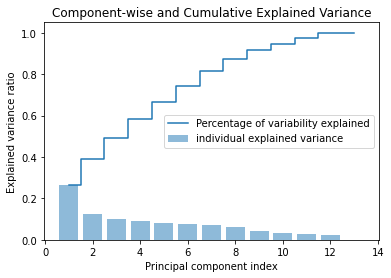

In [0]:
pca_plot(X_train_scaled)

We can use PC1-PC6 to present more than 80% of its information.

In [0]:
from sklearn.decomposition import PCA
def pca(x,i):
  # perform PCA on dataset
  pca = PCA(n_components=i)  
  comp = pca.fit_transform(x) 

  # Returns the variance caused by each of the principal components
  explained_variance = pca.explained_variance_ratio_  
  print("Variance for each principle component:" ,explained_variance)
  print("Components contain ", sum(explained_variance)*100, "% of information")
  labels=[]
  for j in range(i):
    labels.append('PC'+str(j+1))
  df = pd.DataFrame(data = comp, columns = labels)
  return df

In [0]:
X_train_PCA=pca(X_train_scaled,6)

Variance for each principle component: [0.26565042 0.12526045 0.10059306 0.09057252 0.08334954 0.07796603]
Components contain  74.33920234511307 % of information


In [0]:
X_test_PCA=pca(X_test_scaled,6)

Variance for each principle component: [0.25360035 0.12725332 0.1214818  0.09136964 0.0824531  0.08069936]
Components contain  75.68575742632592 % of information


# **Final Modeling & Modeling Comparison & Conclusion**

In [0]:
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import  KFold, cross_val_score

In [0]:
def apply_mls_plot(scores_final,models_final):
  names.clear()
  for sco_str in scores_final:
    print('---Training:'+sco_str)
    results_x_train = []
    apply_ml(models_final,results_x_train,sco_str,X_train_PCA,y_train)
    print('---testing:'+sco_str)
    results_x_test = []
    apply_ml(models_final,results_x_test,sco_str,X_test_PCA,y_test)
    plt.figure()
    models=models_final
    plot_results(results_x_train,'training('+sco_str+')')
    plot_results(results_x_test,'testing('+sco_str+')')
    plt.show()
    results_x_train.clear()
    results_x_test.clear()
    names.clear()

In [0]:
def apply_ml(models_x,results,score,X, y):  
  for name_str, model in models_x:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=score)
    results.append(cv_results)
    names.append(name_str)
    print("%s: %f (%f)" % (name_str, cv_results.mean(), cv_results.var()))

In [0]:
def plot_results(results,str_type):
  fig = plt.figure(figsize=(11,6))
  fig.suptitle('Algorithm Comparison:'+str_type)
  ax = fig.add_subplot(111)
  plt.boxplot(results)
  ax.set_xticklabels(names)
  plt.show()

In [0]:
names=[]
seed=7

In [0]:
models_final = []
models_final.append(('LogReg', LogisticRegression(C=10, solver='lbfgs')))
models_final.append(('XGBoost', XGBClassifier()))
models_final.append(('Ran Forest', RandomForestClassifier()))
models_final.append(('SVM', SVC(gamma='auto')))
models_final.append(('KNN', KNeighborsClassifier(n_neighbors=5)))
models_final.append(('NaiveBayes', GaussianNB()))

In [0]:
models_final

[('LogReg',
  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                     intercept_scaling=1, l1_ratio=None, max_iter=100,
                     multi_class='auto', n_jobs=None, penalty='l2',
                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                     warm_start=False)),
 ('XGBoost',
  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0,
                learning_rate=0.1, max_delta_step=0, max_depth=3,
                min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
                nthread=None, objective='binary:logistic', random_state=0,
                reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
                silent=None, subsample=1, verbosity=1)),
 ('Ran Forest',
  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                         criterion='gini', max_depth=None, ma

In [0]:
scores_final=['accuracy','precision','recall','roc_auc','f1']

---Training:accuracy
LogReg: 0.699801 (0.000270)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBoost: 0.715936 (0.000200)
Ran Forest: 0.687925 (0.000228)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.720656 (0.000171)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.681686 (0.000335)
NaiveBayes: 0.704673 (0.000142)
---testing:accuracy
LogReg: 0.718740 (0.001151)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBoost: 0.730924 (0.001018)
Ran Forest: 0.726689 (0.000973)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.740063 (0.001364)
KNN: 0.706622 (0.000677)
NaiveBayes: 0.723618 (0.001444)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


<Figure size 432x288 with 0 Axes>

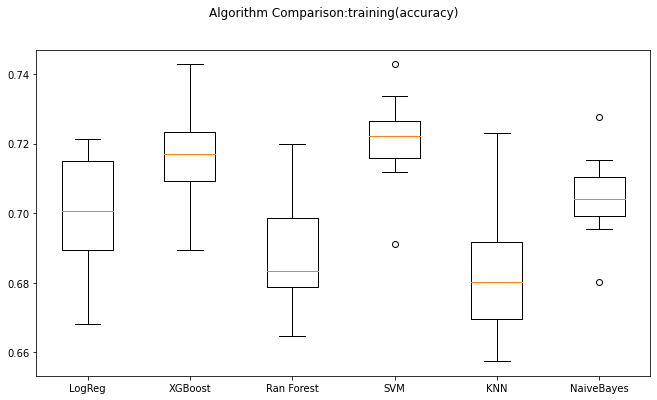

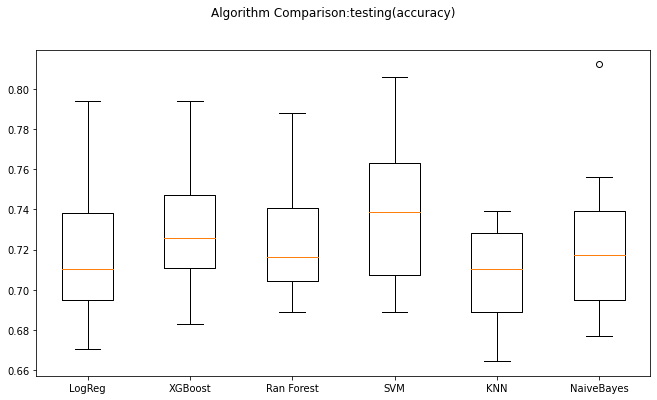

---Training:precision
LogReg: 0.755390 (0.001000)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBoost: 0.800149 (0.000568)
Ran Forest: 0.611135 (0.001105)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.815223 (0.000512)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.599668 (0.000732)
NaiveBayes: 0.729944 (0.000364)
---testing:precision
LogReg: 0.775545 (0.005693)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBoost: 0.776357 (0.003695)
Ran Forest: 0.666583 (0.004030)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.856817 (0.002941)
KNN: 0.650691 (0.000958)
NaiveBayes: 0.783071 (0.005842)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


<Figure size 432x288 with 0 Axes>

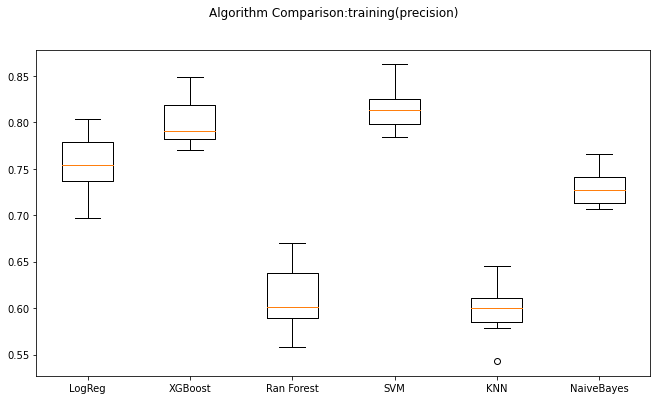

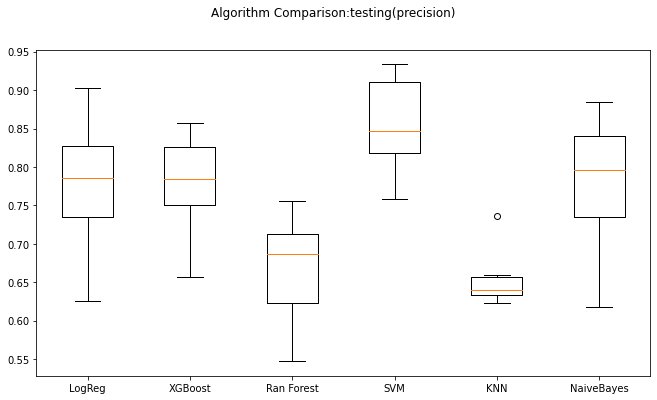

---Training:recall
LogReg: 0.314806 (0.000825)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBoost: 0.341140 (0.001214)
Ran Forest: 0.491794 (0.001305)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.345998 (0.000965)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.496206 (0.001565)
NaiveBayes: 0.357970 (0.000987)
---testing:recall
LogReg: 0.373627 (0.002525)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBoost: 0.416217 (0.001516)
Ran Forest: 0.515385 (0.003626)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.386424 (0.002721)
KNN: 0.498414 (0.001889)
NaiveBayes: 0.384968 (0.002714)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


<Figure size 432x288 with 0 Axes>

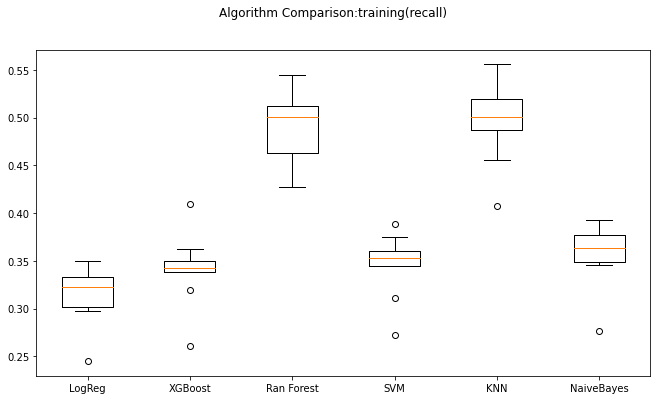

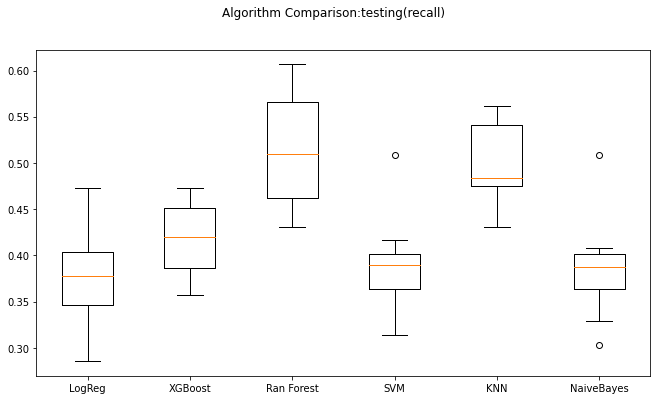

---Training:roc_auc
LogReg: 0.618024 (0.001004)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBoost: 0.721679 (0.000245)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Ran Forest: 0.710440 (0.000477)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.710463 (0.000437)
KNN: 0.699315 (0.000513)
NaiveBayes: 0.647628 (0.000856)
---testing:roc_auc


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


LogReg: 0.633499 (0.002320)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBoost: 0.722111 (0.001891)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Ran Forest: 0.730339 (0.001367)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.715720 (0.003082)
KNN: 0.705443 (0.001055)
NaiveBayes: 0.663714 (0.001690)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


<Figure size 432x288 with 0 Axes>

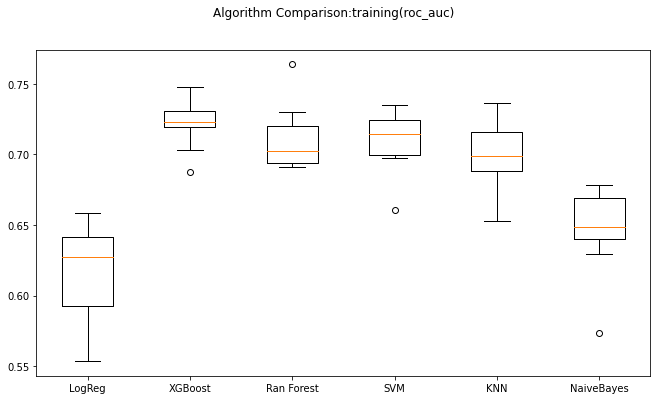

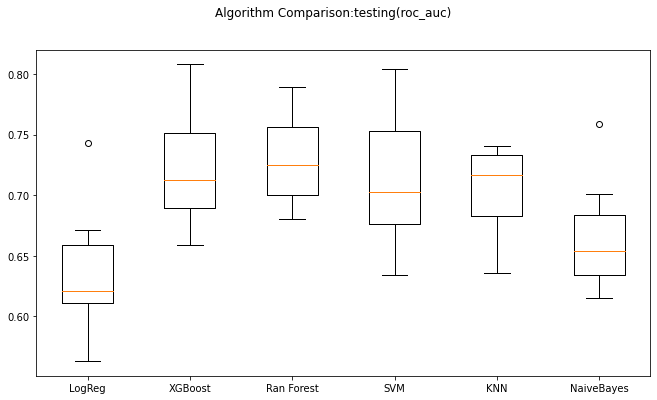

---Training:f1
LogReg: 0.443850 (0.001045)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBoost: 0.477070 (0.001163)
Ran Forest: 0.552417 (0.000850)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.484994 (0.001045)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


KNN: 0.542502 (0.001044)
NaiveBayes: 0.479562 (0.000949)
---testing:f1
LogReg: 0.501885 (0.002794)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


XGBoost: 0.540731 (0.001677)
Ran Forest: 0.583303 (0.002599)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.530418 (0.002547)
KNN: 0.563174 (0.000957)
NaiveBayes: 0.514221 (0.003125)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


<Figure size 432x288 with 0 Axes>

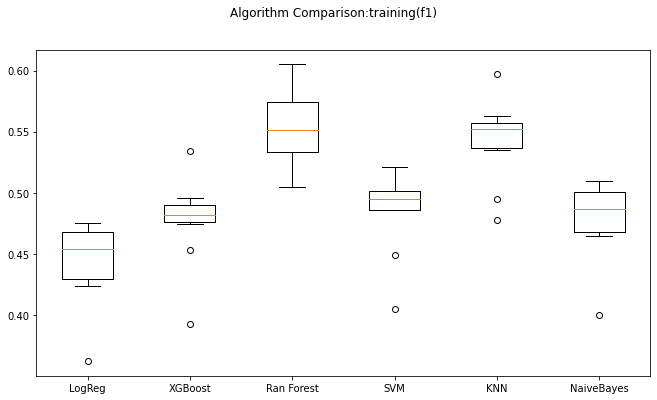

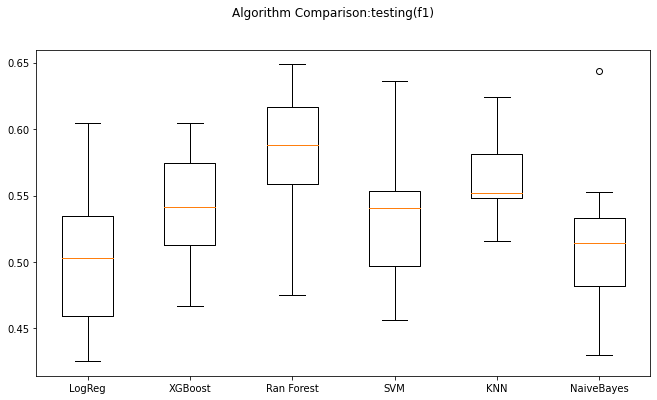

In [0]:
apply_mls_plot(scores_final,models_final)

In [0]:
#print(X)

# **After Features Selection**

In [0]:
X_after_sel = [
    'BuiltWith-ActiveTechCount', 'IPqwery-PatentsGranted', 'NumberofInvestors','NumberofFounders',
    'NumberofFundingRounds','EstimatedRevenueRange_$1M to $10M', 'EstimatedRevenueRange_unknown',
     'NumberofLeadInvestors','inv_by_famous_investor','FundingStatus_Early Stage Venture','FundingStatus_Late Stage Venture',
    'HeadquartersLocation_new_Sf_around'#,'NumberofEmployees_new','HeadquartersLocation_new','TotalFundingAmountCurrency'
]


#cannot import LastEquityFundingAmountCurrency(inUSD), features with (inUSD)
X_after = df_clean[X_after_sel]

In [0]:
X_aft = X_after
X_aft['intercept'] = 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
y = df_clean.target

,BuiltWith-ActiveTechCount,IPqwery-PatentsGranted,NumberofInvestors,NumberofFounders,NumberofFundingRounds,EstimatedRevenueRange_$1M to $10M,EstimatedRevenueRange_unknown,NumberofLeadInvestors,inv_by_famous_investor,FundingStatus_Early Stage Venture,FundingStatus_Late Stage Venture,HeadquartersLocation_new_Sf_around,intercept
0,11.0,0.0,2.0,2.000000,1,0,1,0.0,0,0,0,0,1
1,23.0,0.0,5.0,2.000000,2,0,0,2.0,0,1,0,0,1
2,13.0,0.0,8.0,2.000000,6,0,0,2.0,0,0,1,1,1
3,14.0,5.0,0.0,2.000000,1,0,1,0.0,0,0,0,0,1
4,31.0,0.0,6.0,1.000000,4,1,0,3.0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8443,9.0,0.0,4.0,2.038336,1,0,1,1.0,0,1,0,0,1
8444,4.0,0.0,0.0,1.000000,2,0,1,0.0,0,0,0,0,1
8445,0.0,0.0,7.0,2.038336,1,0,1,1.0,0,1,0,0,1
8446,4.0,0.0,0.0,2.000000,1,0,1,0.0,0,0,0,0,1


# **Modeling After Features Selection**

In [0]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have 
# similar proportions of either target class
X_train, X_test, y_train, y_test = train_test_split(X_aft,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=40,
                                                    stratify=y)

In [0]:
# Standardize the data

scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

In [0]:
#apply_mls_plot(scores_final,models_final)

# **Final Input & Output**

In [0]:
LGP = LogisticRegression().fit(X_train_scaled, y_train)

In [0]:
df_clean.columns

Index(['target', 'IPqwery-PatentsGranted', 'BuiltWith-ActiveTechCount',
       'NumberofFounders', 'NumberofFundingRounds', 'NumberofInvestors',
       'NumberofLeadInvestors', 'inv_by_famous_investor',
       'EstimatedRevenueRange_$10M+', 'EstimatedRevenueRange_$1M to $10M',
       'EstimatedRevenueRange_Less than $1M', 'EstimatedRevenueRange_unknown',
       'FundingStatus_Early Stage Venture', 'FundingStatus_Late Stage Venture',
       'FundingStatus_Seed', 'HeadquartersLocation_new_North_East_Bay',
       'HeadquartersLocation_new_Sf_around',
       'HeadquartersLocation_new_South_Bay',
       'HeadquartersLocation_new_others'],
      dtype='object')

In [0]:
df_clean.shape

(8212, 19)

In [0]:
Final_input = df_clean.iloc[:, 1:]
Final_input.shape

(8212, 18)

In [0]:
Final_input.columns

Index(['IPqwery-PatentsGranted', 'BuiltWith-ActiveTechCount',
       'NumberofFounders', 'NumberofFundingRounds', 'NumberofInvestors',
       'NumberofLeadInvestors', 'inv_by_famous_investor',
       'EstimatedRevenueRange_$10M+', 'EstimatedRevenueRange_$1M to $10M',
       'EstimatedRevenueRange_Less than $1M', 'EstimatedRevenueRange_unknown',
       'FundingStatus_Early Stage Venture', 'FundingStatus_Late Stage Venture',
       'FundingStatus_Seed', 'HeadquartersLocation_new_North_East_Bay',
       'HeadquartersLocation_new_Sf_around',
       'HeadquartersLocation_new_South_Bay',
       'HeadquartersLocation_new_others'],
      dtype='object')

In [0]:
Final_input.shape[1]

18

In [0]:
input_f=[]
for i in range(Final_input.shape[1]):
    print(Final_input.columns.values[i])
    input_f.append(input())

IPqwery-PatentsGranted
1
BuiltWith-ActiveTechCount
1
NumberofFounders
1
NumberofFundingRounds
1
NumberofInvestors
1
NumberofLeadInvestors
1
inv_by_famous_investor
1
EstimatedRevenueRange_$10M+
1
EstimatedRevenueRange_$1M to $10M
1
EstimatedRevenueRange_Less than $1M
1
EstimatedRevenueRange_unknown
1
FundingStatus_Early Stage Venture
1
FundingStatus_Late Stage Venture
1
FundingStatus_Seed
1
HeadquartersLocation_new_North_East_Bay
1
HeadquartersLocation_new_Sf_around
1
HeadquartersLocation_new_South_Bay
1
HeadquartersLocation_new_others
1


In [0]:
a = np.array(input_f)
print(a)

['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1']


In [0]:
b = a.astype(np.float) 
b = b.reshape(1, -1)

In [0]:
print(b)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [0]:
sc = StandardScaler()
x_input= sc.fit_transform(b)
LGP.predict(x_input)

array([0])